# Прошкин Георгий ИУ5-61Б

Тема датасета:
    Рак груди

Основная задача:
    Классификация опухолей на злокачественные (раковые) или доброкачественные (не раковые).

Содержание датасета:
    
    mean_radius: радиус долей.
    
    mean_texture: среднее значение текстуры поверхности.
    
    mean_perimeter: внешний периметр долей.
    
    mean_area: средняя площадь долей.
    
    mean_smoothness: среднее значение уровней гладкости.
    
    diagnosis: поставленный диагноз (целевой признак).

In [2]:
#Импорт библиотек
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
%matplotlib inline 
sns.set(style="ticks")
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Загрузка данных
data = pd.read_csv('Breast_cancer_data.csv')

# Проведение разведочного анализа данных. Построение графиков, необходимых для понимания структуры данных. Анализ и заполнение пропусков в данных.

In [4]:
#Основные характеристики датасета
data

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0
...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0
565,20.13,28.25,131.20,1261.0,0.09780,0
566,16.60,28.08,108.30,858.1,0.08455,0
567,20.60,29.33,140.10,1265.0,0.11780,0


In [5]:
#Размер датасета
data.shape

(569, 6)

In [6]:
# Список колонок
data.columns

Index(['mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area',
       'mean_smoothness', 'diagnosis'],
      dtype='object')

In [7]:
# Список колонок с типами данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mean_radius      569 non-null    float64
 1   mean_texture     569 non-null    float64
 2   mean_perimeter   569 non-null    float64
 3   mean_area        569 non-null    float64
 4   mean_smoothness  569 non-null    float64
 5   diagnosis        569 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 26.8 KB


In [8]:
# Проверим наличие пустых значений
data.isnull().sum()

mean_radius        0
mean_texture       0
mean_perimeter     0
mean_area          0
mean_smoothness    0
diagnosis          0
dtype: int64

# Построение графиков для понимания структуры данных

<AxesSubplot:>

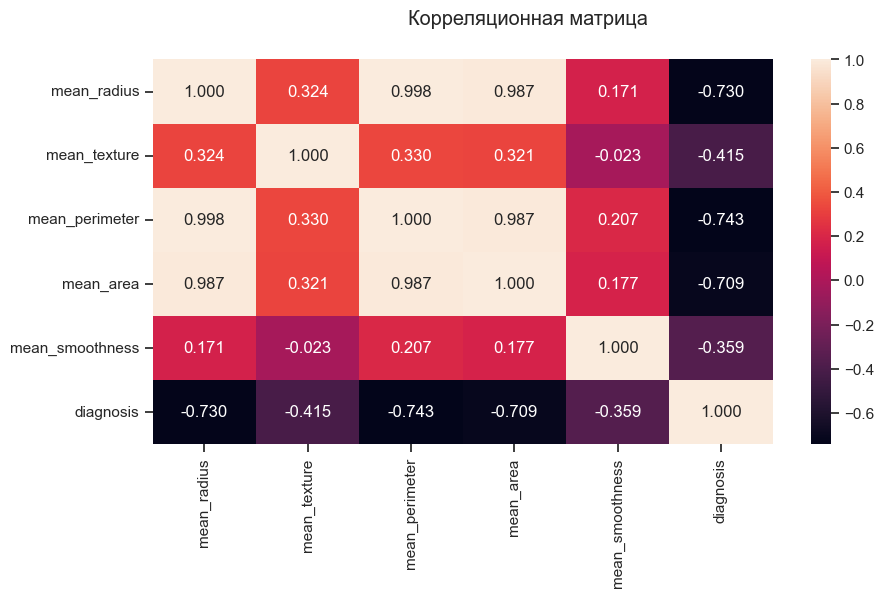

In [9]:
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Корреляционная матрица')
sns.heatmap(data.corr(), ax=ax, annot=True, fmt='.3f')

Из обратной корреляции параметров с итоговым диагнозом становится очевидно, что в исходном датасете доброкачественная опухоль закодирована, как "1", а злокачественная - как "0". Для большего удобства и каноничности представления данных заменим значение доброкачественных опухолей на  "0", а злокачественных на "1".

In [10]:
data['diagnosis'] = data['diagnosis']. replace([0,1], [1,0])

<AxesSubplot:>

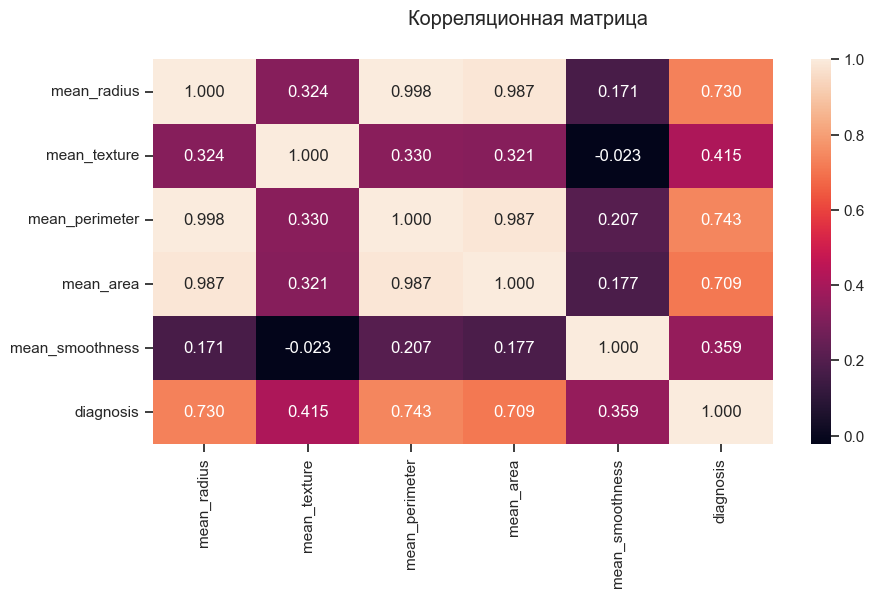

In [11]:
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Корреляционная матрица')
sns.heatmap(data.corr(), ax=ax, annot=True, fmt='.3f')

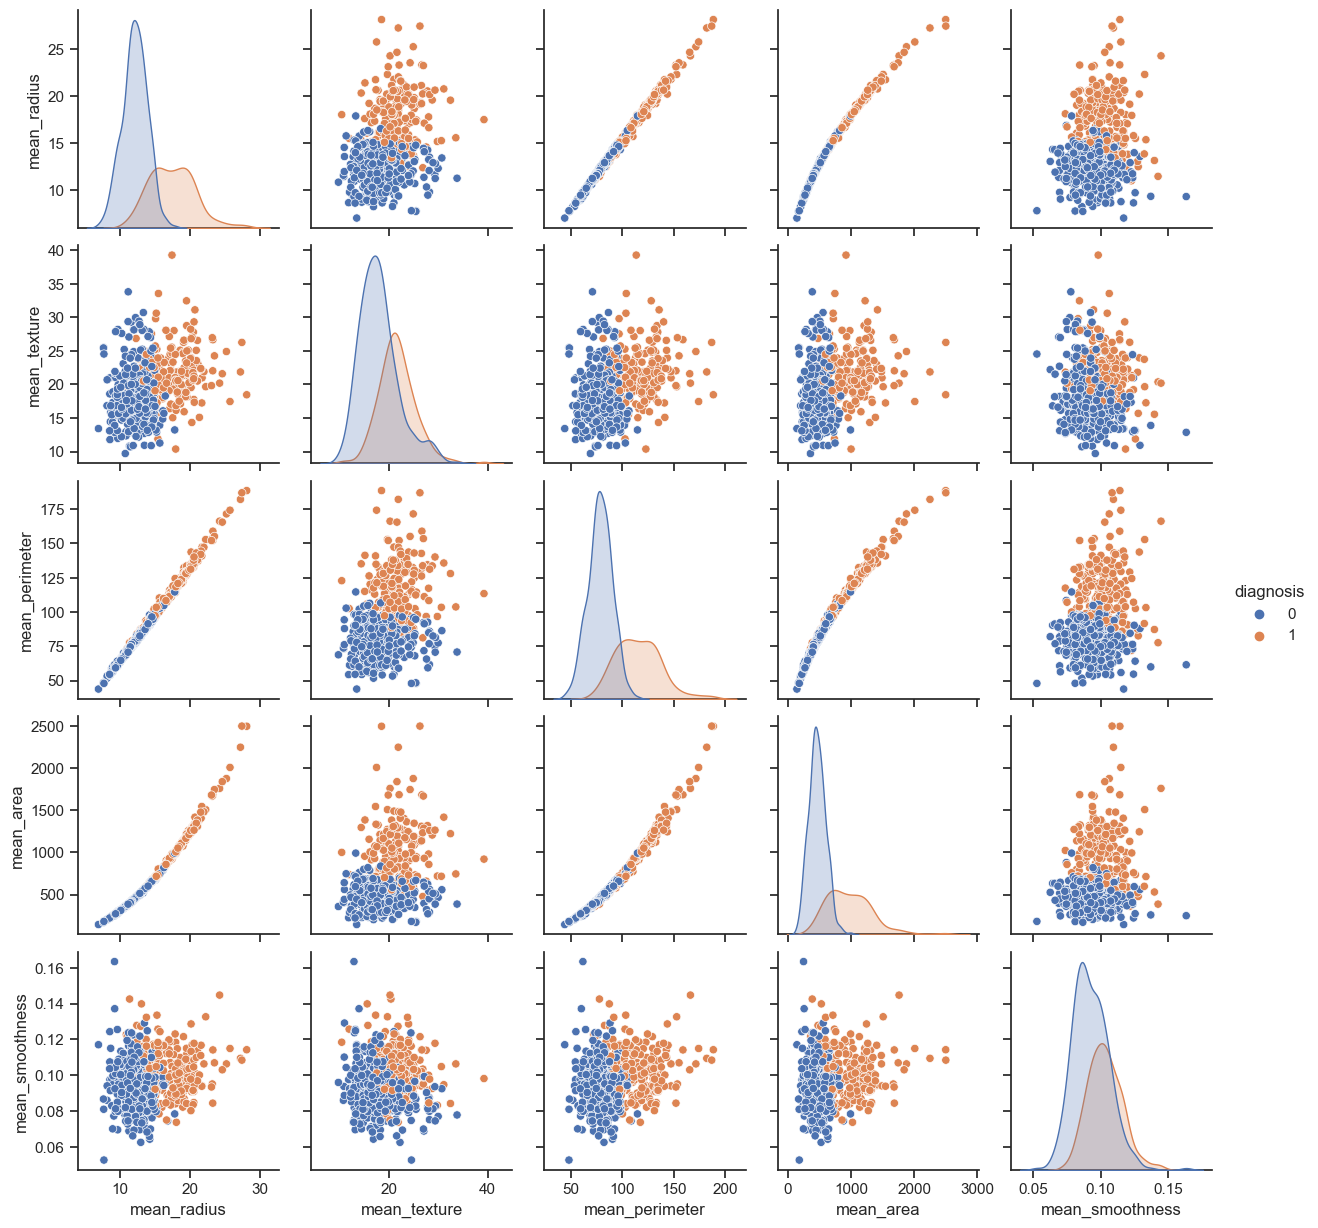

In [12]:
# Парные диаграммы
sns.pairplot(data, hue="diagnosis")

In [13]:
#Оценим количественный дисбаланс целевого признака
data['diagnosis'].value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

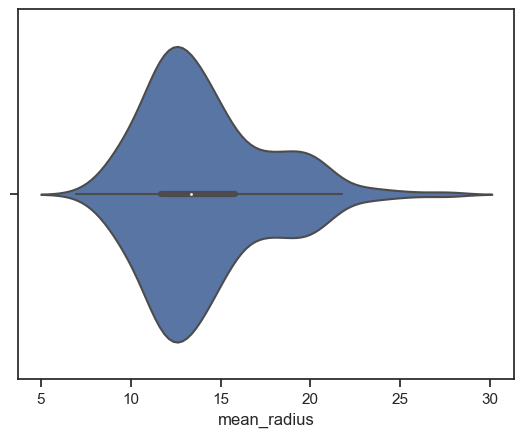

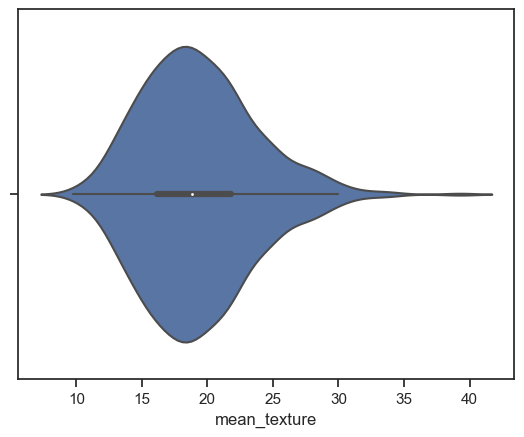

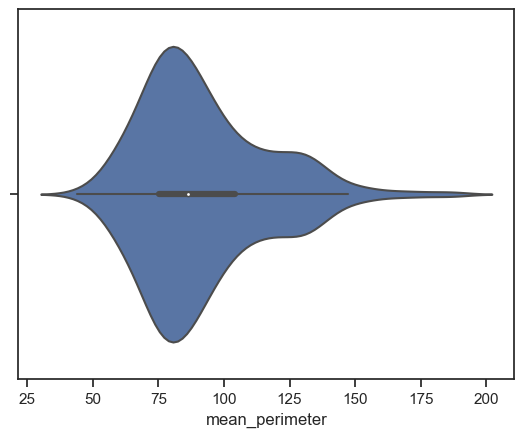

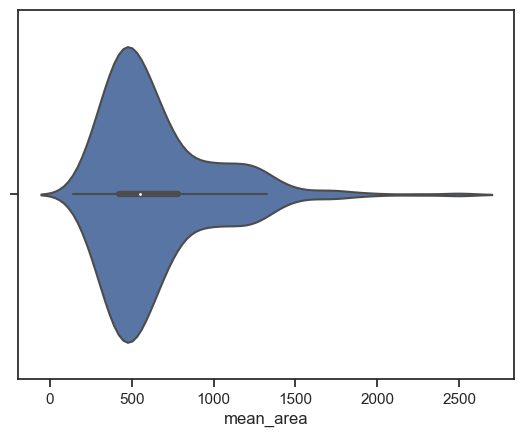

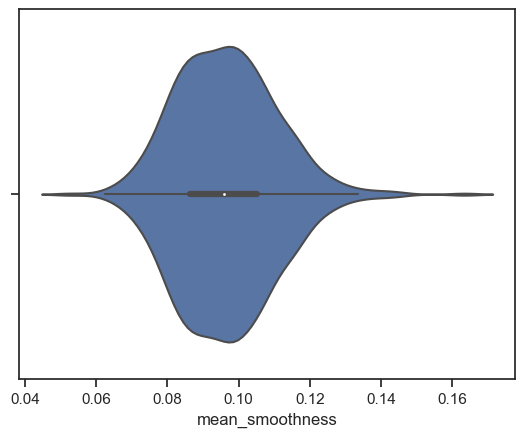

In [14]:
# Скрипичные диаграммы для числовых колонок
for col in ['mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area',
       'mean_smoothness']:
    sns.violinplot(x=data[col])
    plt.show()

# Выбор признаков, подходящих для построения моделей. Кодирование категориальных признаков. Масштабирование данных.

Большинство алгоритмов машинного обучения не могут обрабатывать категориальные переменные, если они не преобразованы в числовые значения, а производительность многих алгоритмов зависит от того, как закодированы категориальные переменные. В нашем случае целевой признак изначально является типом данных "int64", что избавляет нас от необходимости в приобразовании данных. В противном случае мы бы использовали класс "LabelEncoder".

In [15]:
# Числовые колонки для масштабирования
scale_cols = ['mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area',
       'mean_smoothness']

In [16]:
data_df = data

In [17]:
scaler = MinMaxScaler()

In [18]:
#Масштабируем колонки, входящие в список "scale_cols"
scaled_data = scaler.fit_transform(data_df[scale_cols])

In [19]:
scaled_data

array([[0.52103744, 0.0226581 , 0.54598853, 0.36373277, 0.59375282],
       [0.64314449, 0.27257355, 0.61578329, 0.50159067, 0.28987993],
       [0.60149557, 0.3902604 , 0.59574321, 0.44941676, 0.51430893],
       ...,
       [0.45525108, 0.62123774, 0.44578813, 0.30311771, 0.28816467],
       [0.64456434, 0.66351031, 0.66553797, 0.4757158 , 0.58833619],
       [0.03686876, 0.50152181, 0.02853984, 0.01590668, 0.        ]])

In [20]:
#В переменную scaled_data был записан массив Numpy. Его нужно вновь преобразовать в датафрейм.
df_scaled_data = pd.DataFrame(scaled_data, columns = list(scale_cols))

In [21]:
df_scaled_data

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness
0,0.521037,0.022658,0.545989,0.363733,0.593753
1,0.643144,0.272574,0.615783,0.501591,0.289880
2,0.601496,0.390260,0.595743,0.449417,0.514309
3,0.210090,0.360839,0.233501,0.102906,0.811321
4,0.629893,0.156578,0.630986,0.489290,0.430351
...,...,...,...,...,...
564,0.690000,0.428813,0.678668,0.566490,0.526948
565,0.622320,0.626987,0.604036,0.474019,0.407782
566,0.455251,0.621238,0.445788,0.303118,0.288165
567,0.644564,0.663510,0.665538,0.475716,0.588336


In [22]:
#Добавим к масштабированным данным немасштабированную целевую переменную
df_scaled_data['diagnosis'] = data_df['diagnosis']

In [23]:
df_scaled_data

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,0.521037,0.022658,0.545989,0.363733,0.593753,1
1,0.643144,0.272574,0.615783,0.501591,0.289880,1
2,0.601496,0.390260,0.595743,0.449417,0.514309,1
3,0.210090,0.360839,0.233501,0.102906,0.811321,1
4,0.629893,0.156578,0.630986,0.489290,0.430351,1
...,...,...,...,...,...,...
564,0.690000,0.428813,0.678668,0.566490,0.526948,1
565,0.622320,0.626987,0.604036,0.474019,0.407782,1
566,0.455251,0.621238,0.445788,0.303118,0.288165,1
567,0.644564,0.663510,0.665538,0.475716,0.588336,1


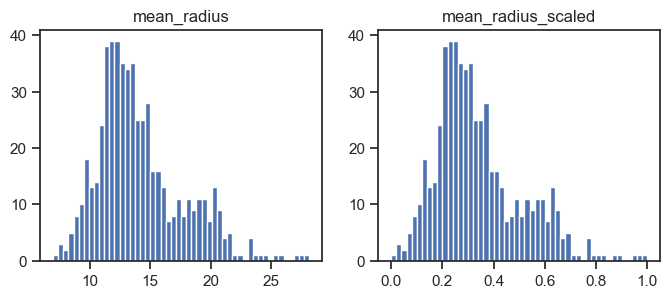

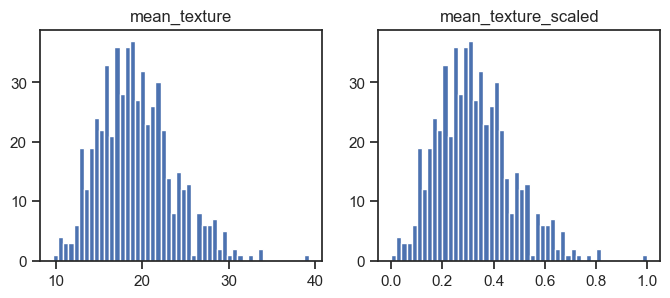

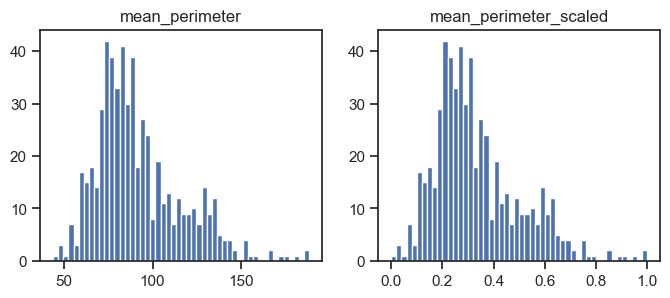

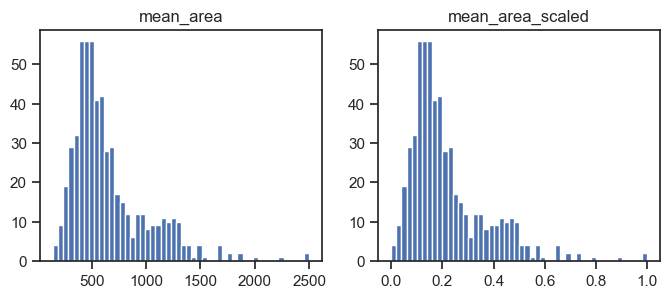

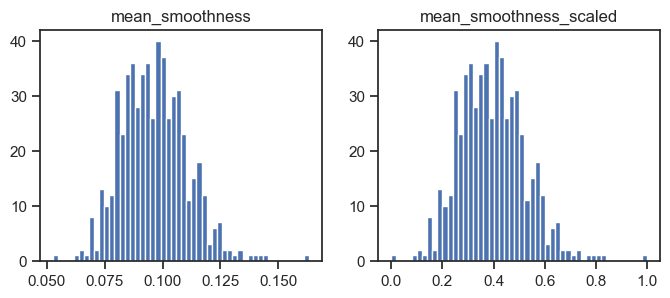

In [24]:
# Проверим, что масштабирование не повлияло на распределение данных
for col in scale_cols:
    fig, ax = plt.subplots(1, 2, figsize=(8,3))
    ax[0].hist(data[col], 50)
    ax[1].hist(df_scaled_data[col], 50)
    ax[0].title.set_text(col)
    ax[1].title.set_text(col + "_scaled")
    plt.show()

# Проведение корреляционного анализа данных. Формирование промежуточных выводов о возможности построения моделей машинного обучения

<AxesSubplot:>

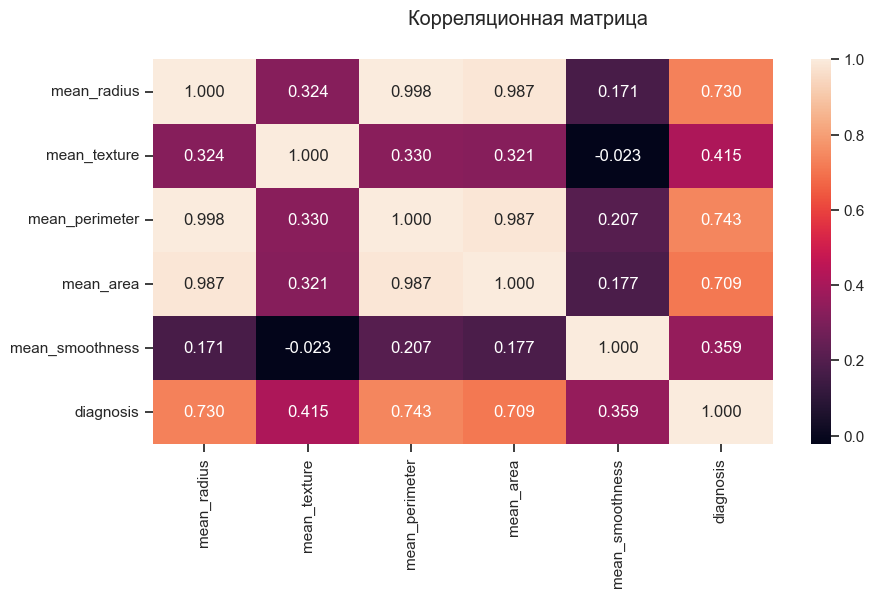

In [25]:
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Корреляционная матрица')
sns.heatmap(data.corr(), ax=ax, annot=True, fmt='.3f')

<AxesSubplot:>

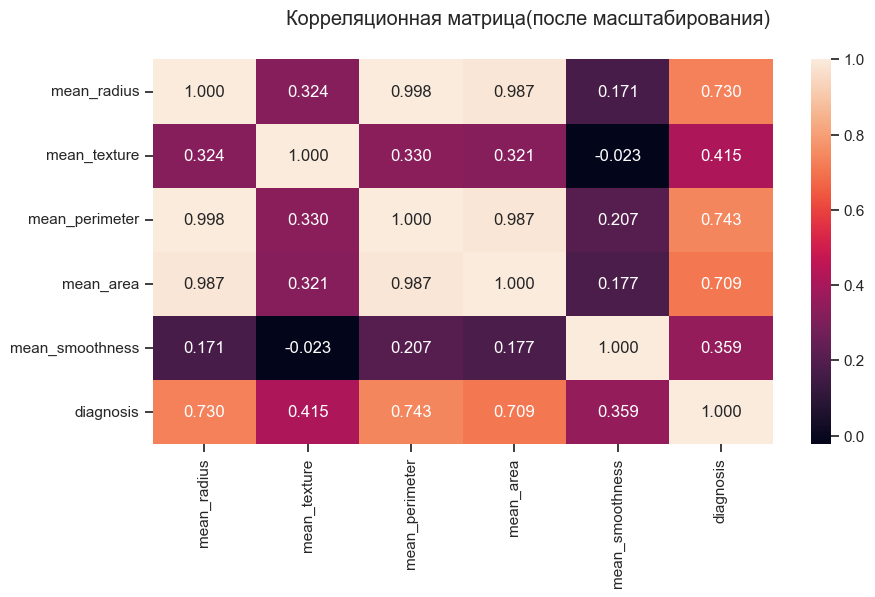

In [26]:
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Корреляционная матрица(после масштабирования)')
sns.heatmap(df_scaled_data.corr(), ax=ax, annot=True, fmt='.3f')

На основе корреляционной матрицы можно сделать следующие выводы:
Корреляционные матрицы для исходных и масштабированных данных совпадают.
Целевой признак классификации "diagnosis" наиболее сильно коррелирует с mean_radius (0.73), mean_perimeter (0.743) и mean_area (0.709). Эти признаки обязательно следует оставить в модели классификации.

# Формирование обучающей и тестовой выборок на основе исходного набора данных.

In [27]:
features = list(df_scaled_data.iloc [:, 0:5])
targets = list(df_scaled_data.iloc [:, 5:6])
print(features)
print(targets)

['mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area', 'mean_smoothness']
['diagnosis']


In [28]:
x = df_scaled_data[features]
y = df_scaled_data['diagnosis']

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.3, 
                                                    random_state = 42)

# Выбор наиболее подходящих моделей для решения задачи классификации.


Для задачи классификации будем использовать следующие модели:
    
    Метод ближайших соседей
    
    Метод опорных векторов
    
    Дерево решений
    
    Случайный лес
    
    Градиентный бустинг

# Выбор метрик для последующей оценки качества моделей.

Для задачи классификации выберем метки, основанные на матрице ошибок.

Будем использовать метрики:

    balanced accuracy - доля верных предсказаний. Метрика используется в случае дисбаланса классов при бинарной классификации. 
    
    precision(точность) - отношение TP к TP + FP. Доля верных положительных предсказаний среди всех положительных предсказаний. Показывает, отличает ли модель один класс от другого. Применяется в случае дисбаланса классов.
    
    recall(полнота) - отношение TP к TP + FN. Доля верных положительных предсказаний среди всех положительных объектов набора. Показывает, может ли модель определить класс. Применяется в случае дисбаланса классов.
    
    F1-мера - среднее гармоническое от precision и recall. Не учитывает верные негативные предсказания. Применяется в случае дисбаланса классов.

In [30]:
def print_metrics(model, y_test, y_pred):
    acc = balanced_accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))
    rec = recall_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))
    f1 = f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))
    print(f"Balanced Accuracy: {acc}")
    print(f"Precision: {prec}")
    print(f"Recall: {rec}")
    print(f"F1: {f1}")
    result = pd.DataFrame({'values': [ acc, prec, rec, f1 ], 'metrics': ['Balanced Accuracy', 'Precision','Recall','F1'] })
    ax = result.plot.barh(x='metrics', y='values')
    plot_confusion_matrix(model, x_train, y_train.values,
                          display_labels=['0','1'],
                          cmap=plt.cm.Blues, normalize='true')
    plt.show()

# Построение базового решения (baseline) для выбранных моделей без подбора гиперпараметров.
Производится обучение моделей на основе обучающей выборки и оценка качества моделей на основе тестовой выборки.

KNN_5
Balanced Accuracy: 0.9292328042328042
Precision: 0.9355228111711654
Recall: 0.935672514619883
F1: 0.9355634246907591


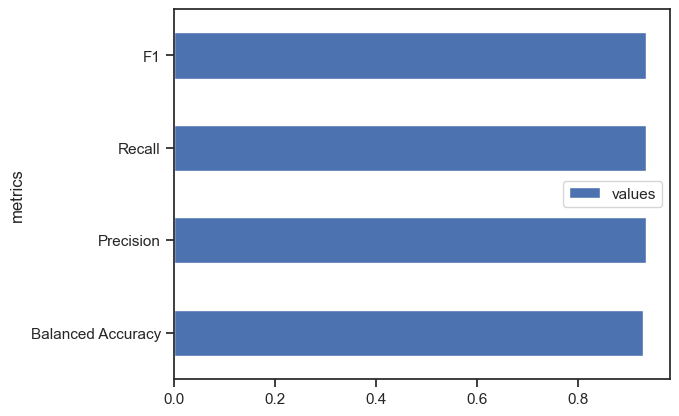

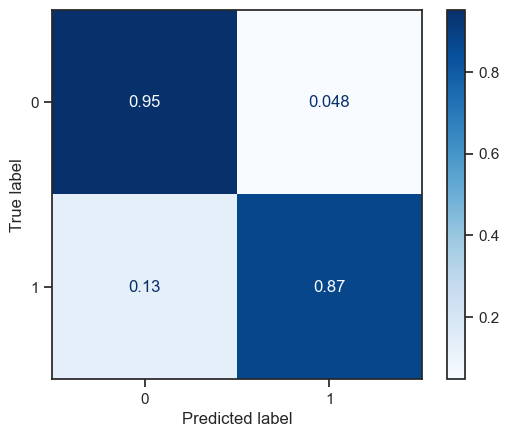

SVC
Balanced Accuracy: 0.9636243386243386
Precision: 0.9711000474158369
Recall: 0.9707602339181286
F1: 0.970603923775359


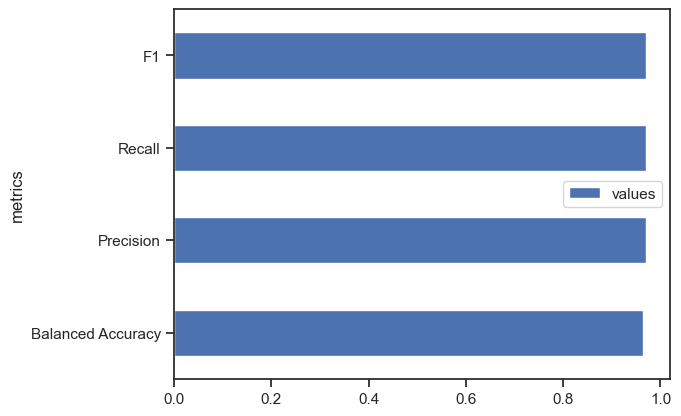

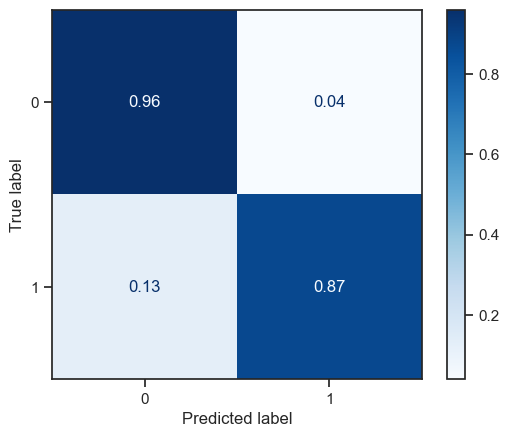

Tree
Balanced Accuracy: 0.873015873015873
Precision: 0.878879015721121
Recall: 0.8771929824561403
F1: 0.8777561328805144


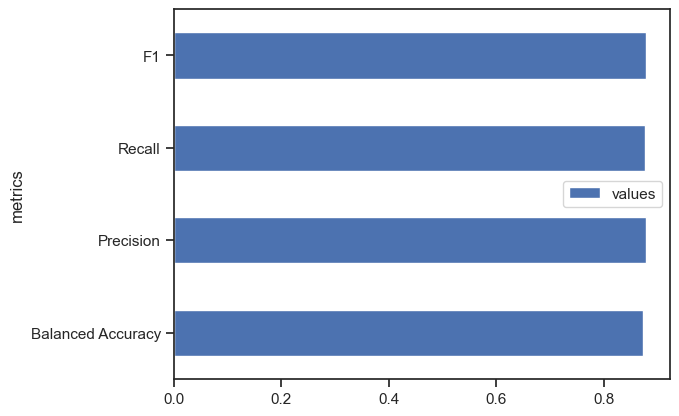

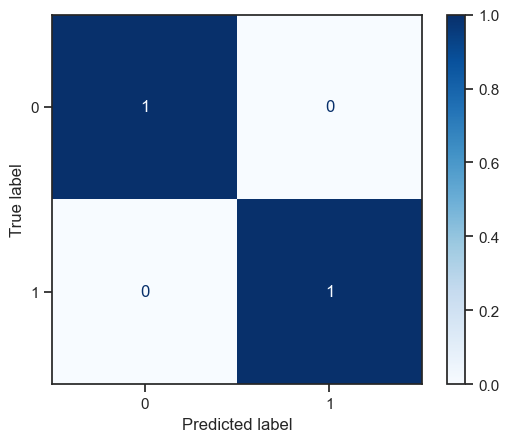

RandomForest
Balanced Accuracy: 0.9781746031746031
Precision: 0.9770376594606983
Recall: 0.9766081871345029
F1: 0.9766816281357601


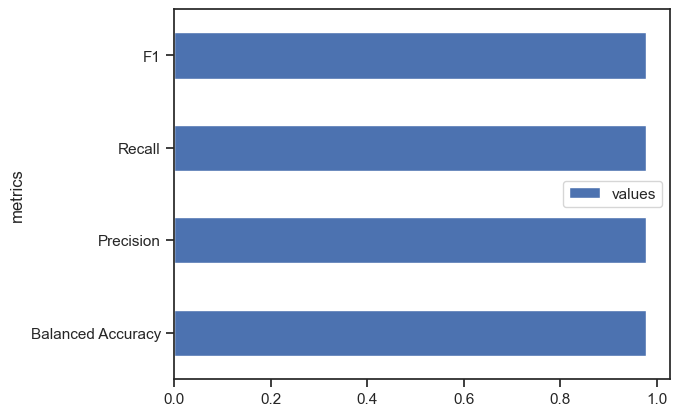

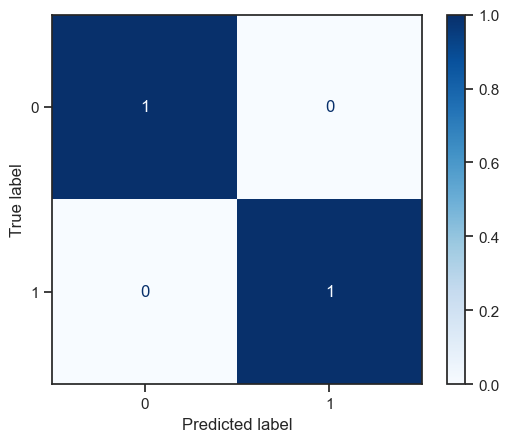

GradientBoosting
Balanced Accuracy: 0.9563492063492063
Precision: 0.9548613209257356
Recall: 0.9532163742690059
F1: 0.9534947673974487


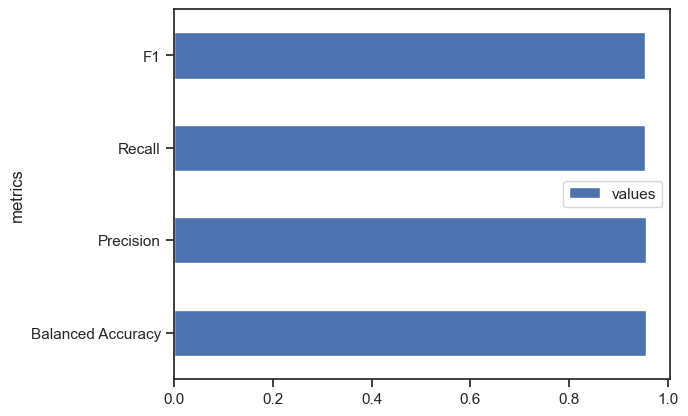

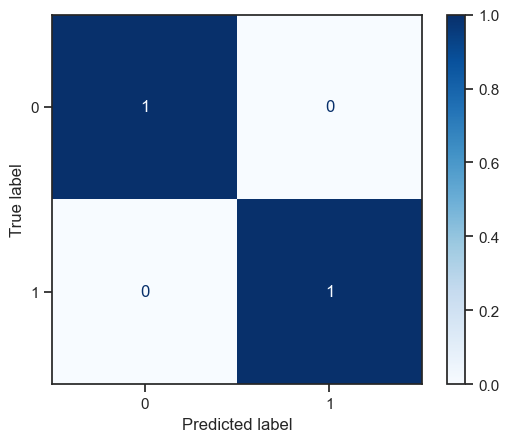

In [31]:
models = {'KNN_5':KNeighborsClassifier(n_neighbors=5),
          'SVC':SVC(),
          'Tree':DecisionTreeClassifier(),
          'RandomForest':RandomForestClassifier(),
          'GradientBoosting':GradientBoostingClassifier()}
for name, model in models.items():
    est = model.fit(x_train, y_train)
    y_pred = est.predict(x_test)
    print(name)
    print_metrics(model, y_test, y_pred)

Лучшие результаты показывают модели опорных векторов и случайного леса. Модель дерева решений совершает больше всего ошибок.

# Подбор гиперпараметров для выбранных моделей.

Метод ближайших соседей

In [32]:
n_range = np.array(range(1, 200, 4))
knn_parameters = [{'n_neighbors': n_range}]
n_range

array([  1,   5,   9,  13,  17,  21,  25,  29,  33,  37,  41,  45,  49,
        53,  57,  61,  65,  69,  73,  77,  81,  85,  89,  93,  97, 101,
       105, 109, 113, 117, 121, 125, 129, 133, 137, 141, 145, 149, 153,
       157, 161, 165, 169, 173, 177, 181, 185, 189, 193, 197])

In [33]:
gs1 = GridSearchCV(KNeighborsClassifier(), knn_parameters,
                  cv=ShuffleSplit(n_splits=8), scoring='roc_auc',
                  return_train_score=True, n_jobs=-1)
gs1.fit(x, y)

GridSearchCV(cv=ShuffleSplit(n_splits=8, random_state=None, test_size=None, train_size=None),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid=[{'n_neighbors': array([  1,   5,   9,  13,  17,  21,  25,  29,  33,  37,  41,  45,  49,
        53,  57,  61,  65,  69,  73,  77,  81,  85,  89,  93,  97, 101,
       105, 109, 113, 117, 121, 125, 129, 133, 137, 141, 145, 149, 153,
       157, 161, 165, 169, 173, 177, 181, 185, 189, 193, 197])}],
             return_train_score=True, scoring='roc_auc')

График изменения качества на тестовой выборке в зависимости от К-соседей

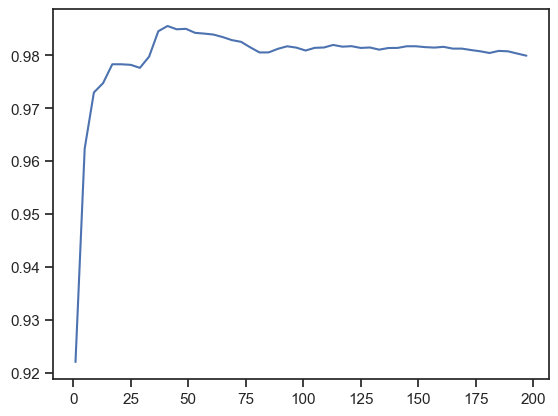

In [34]:
plt.plot(n_range, gs1.cv_results_["mean_test_score"]);

In [35]:
#Лучший параметр
gs1.best_params_

{'n_neighbors': 41}

In [36]:
#Лучший результат
gs1.best_score_

0.9855545419215794

Метод опорных векторов

In [37]:
svm_parameters = [{'C': n_range}]
gs2 = GridSearchCV(SVC(), svm_parameters,
                  cv=8, scoring='roc_auc', n_jobs=-1)
gs2.fit(x, y)

GridSearchCV(cv=8, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': array([  1,   5,   9,  13,  17,  21,  25,  29,  33,  37,  41,  45,  49,
        53,  57,  61,  65,  69,  73,  77,  81,  85,  89,  93,  97, 101,
       105, 109, 113, 117, 121, 125, 129, 133, 137, 141, 145, 149, 153,
       157, 161, 165, 169, 173, 177, 181, 185, 189, 193, 197])}],
             scoring='roc_auc')

График изменения качества на тестовой выборке в зависимости от параметра C

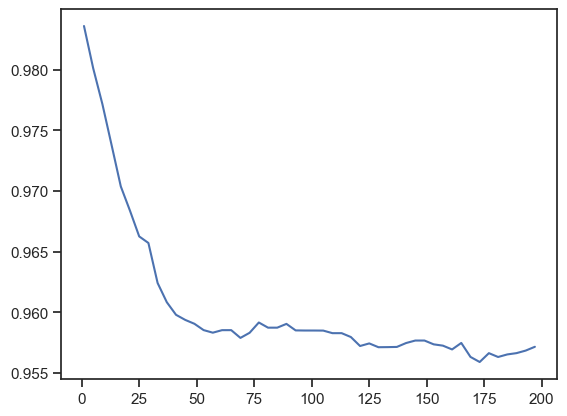

In [38]:
plt.plot(n_range, gs2.cv_results_["mean_test_score"]);

In [39]:
#Лучший параметр
gs2.best_params_

{'C': 1}

In [40]:
#Лучший результат
gs2.best_score_

0.9835941322052434

Решающее дерево

In [41]:
tree_parameters = {'max_depth': n_range, 'criterion': ['gini', 'entropy'], 'min_samples_split': [2,3,4,5]}
gs3 = GridSearchCV(DecisionTreeClassifier(), tree_parameters,
                  cv=ShuffleSplit(n_splits=8), scoring='roc_auc',
                  return_train_score=True, n_jobs=-1)
gs3.fit(x, y)

GridSearchCV(cv=ShuffleSplit(n_splits=8, random_state=None, test_size=None, train_size=None),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([  1,   5,   9,  13,  17,  21,  25,  29,  33,  37,  41,  45,  49,
        53,  57,  61,  65,  69,  73,  77,  81,  85,  89,  93,  97, 101,
       105, 109, 113, 117, 121, 125, 129, 133, 137, 141, 145, 149, 153,
       157, 161, 165, 169, 173, 177, 181, 185, 189, 193, 197]),
                         'min_samples_split': [2, 3, 4, 5]},
             return_train_score=True, scoring='roc_auc')

In [42]:
#Лучшие параметры
gs3.best_params_

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 3}

In [43]:
#Лучший результат
gs3.best_score_

0.9066840646111642

Случайный лес

In [44]:
f_params = {'n_estimators': [50, 100, 120, 150],  'criterion': ['gini', 'entropy'], 'min_samples_leaf': [2,3,4]}
gs4 = GridSearchCV(RandomForestClassifier(), f_params, cv=6, n_jobs=-1, scoring='roc_auc')
gs4.fit(x, y)

GridSearchCV(cv=6, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': [2, 3, 4],
                         'n_estimators': [50, 100, 120, 150]},
             scoring='roc_auc')

In [45]:
#Лучшие параметры
gs4.best_params_

{'criterion': 'entropy', 'min_samples_leaf': 2, 'n_estimators': 100}

In [46]:
#Лучший результат
gs4.best_score_

0.9807120437628911

Градиентный бустинг

In [47]:
param_range = np.arange(10, 300, 20)
gb_params = {'n_estimators': param_range,  'subsample': [0.0, 0.5, 1.0], 'loss': ['log_loss',  'exponential']}
gs5 = GridSearchCV(GradientBoostingClassifier(), gb_params, cv=8, n_jobs=-1, scoring='roc_auc')
gs5.fit(x, y)

GridSearchCV(cv=8, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'loss': ['log_loss', 'exponential'],
                         'n_estimators': array([ 10,  30,  50,  70,  90, 110, 130, 150, 170, 190, 210, 230, 250,
       270, 290]),
                         'subsample': [0.0, 0.5, 1.0]},
             scoring='roc_auc')

In [48]:
#Лучшие параметры
gs5.best_params_

{'loss': 'exponential', 'n_estimators': 90, 'subsample': 0.5}

In [49]:
#Лучший результат
gs5.best_score_

0.9821142335031224

# Сравнение качества полученных моделей с качеством baseline-моделей.

In [50]:
all_models = {'KNN_5':KNeighborsClassifier(n_neighbors=5),'Best KNN': gs1.best_estimator_,
              'SVC':SVC(), 'Best SVC': gs2.best_estimator_,
              'Tree':DecisionTreeClassifier(),  'Best Tree': gs3.best_estimator_,
              'RandomForest':RandomForestClassifier(), 'Best RandomForest': gs4.best_estimator_,
              'GradientBoosting':GradientBoostingClassifier(), 'Best GradientBoosting' : gs5.best_estimator_ }

KNN_5
Balanced Accuracy: 0.9292328042328042
Precision: 0.9355228111711654
Recall: 0.935672514619883
F1: 0.9355634246907591


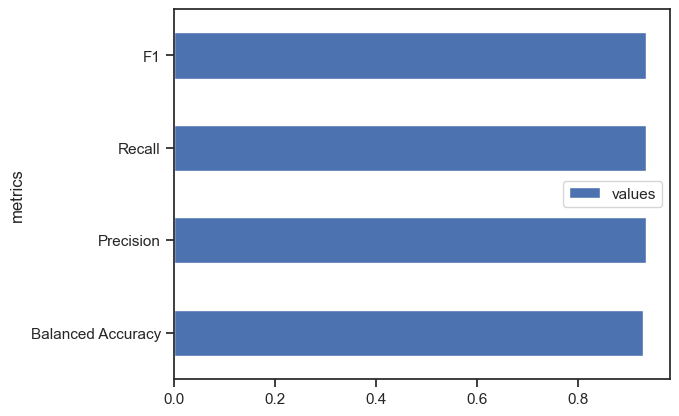

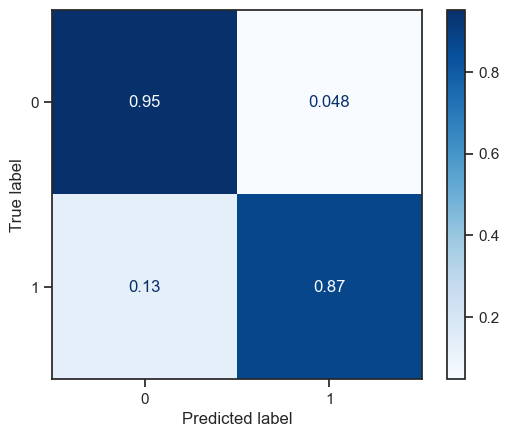

Best KNN
Balanced Accuracy: 0.9636243386243386
Precision: 0.9711000474158369
Recall: 0.9707602339181286
F1: 0.970603923775359


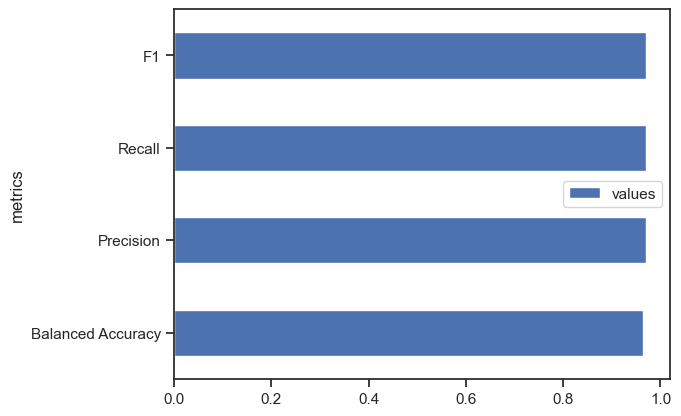

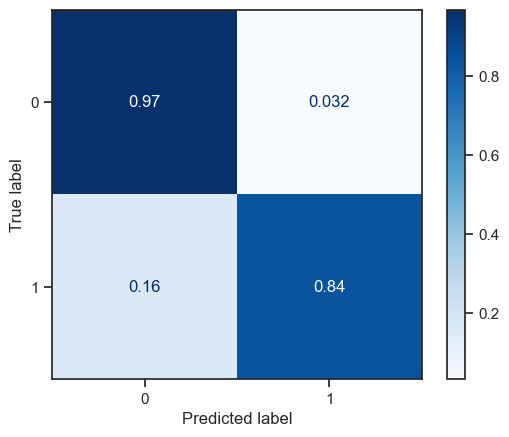

SVC
Balanced Accuracy: 0.9636243386243386
Precision: 0.9711000474158369
Recall: 0.9707602339181286
F1: 0.970603923775359


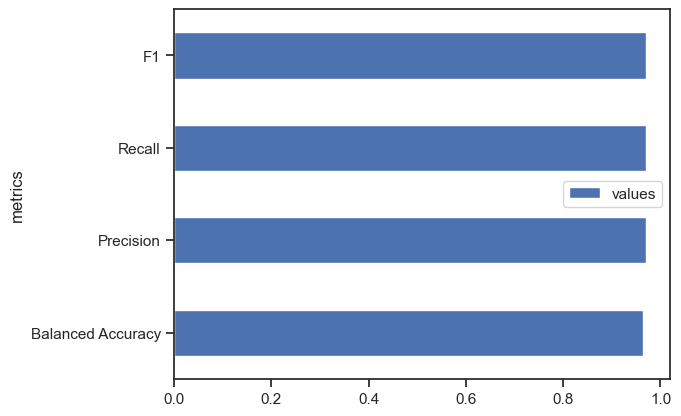

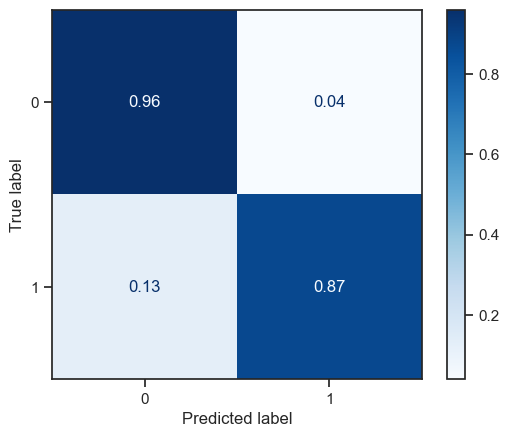

Best SVC
Balanced Accuracy: 0.9636243386243386
Precision: 0.9711000474158369
Recall: 0.9707602339181286
F1: 0.970603923775359


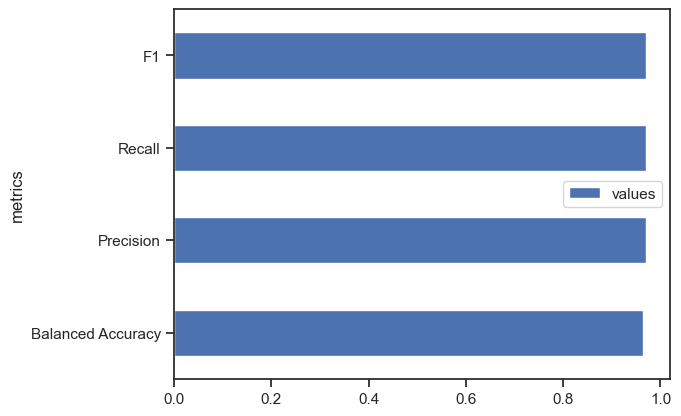

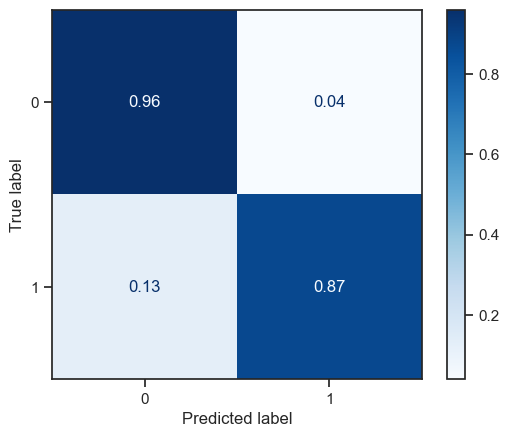

Tree
Balanced Accuracy: 0.8697089947089947
Precision: 0.8776515617314314
Recall: 0.8771929824561403
F1: 0.8773908769359767


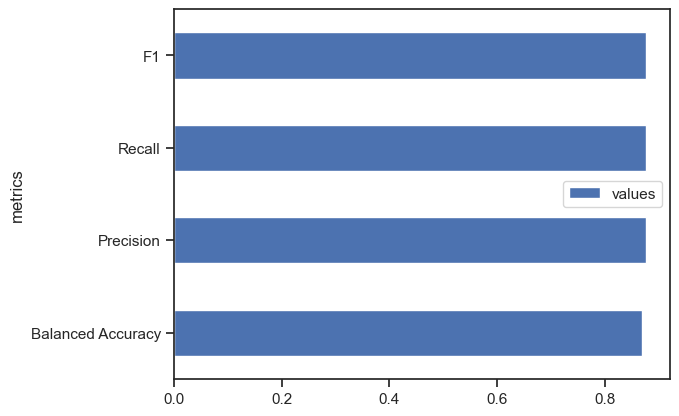

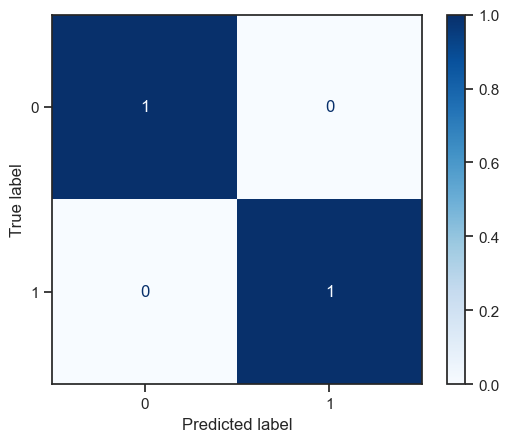

Best Tree
Balanced Accuracy: 0.8974867724867726
Precision: 0.9123476221833191
Recall: 0.9122807017543859
F1: 0.9114606193131384


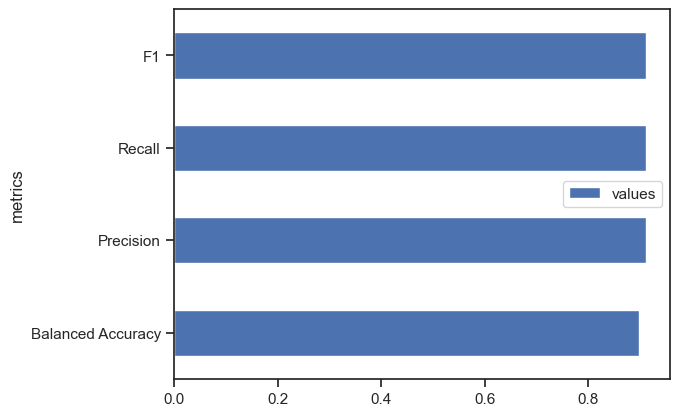

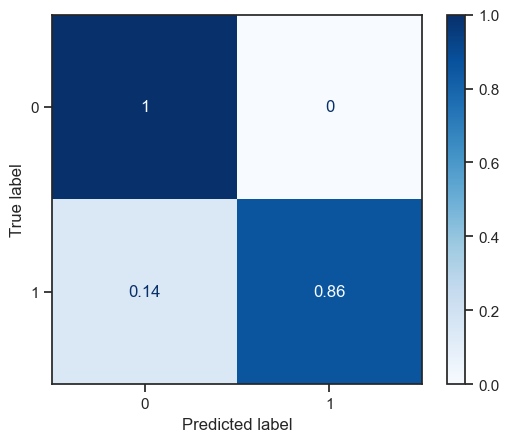

RandomForest
Balanced Accuracy: 0.960978835978836
Precision: 0.9600592390066074
Recall: 0.9590643274853801
F1: 0.9592520442935047


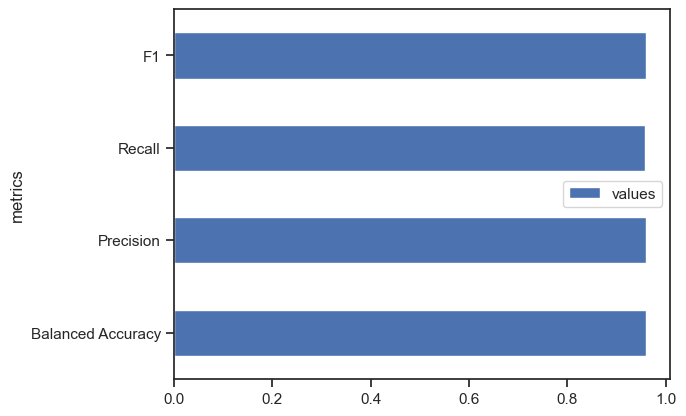

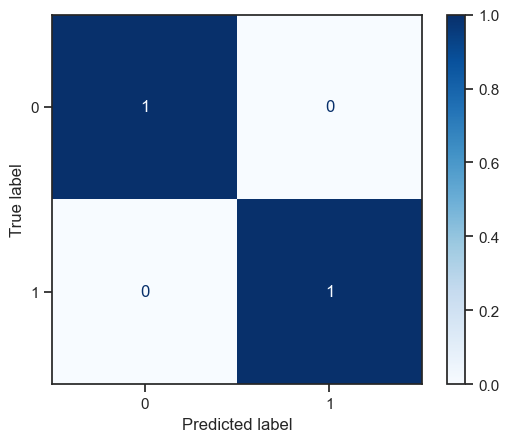

Best RandomForest
Balanced Accuracy: 0.9656084656084656
Precision: 0.9654113513100604
Recall: 0.9649122807017544
F1: 0.9650224422036399


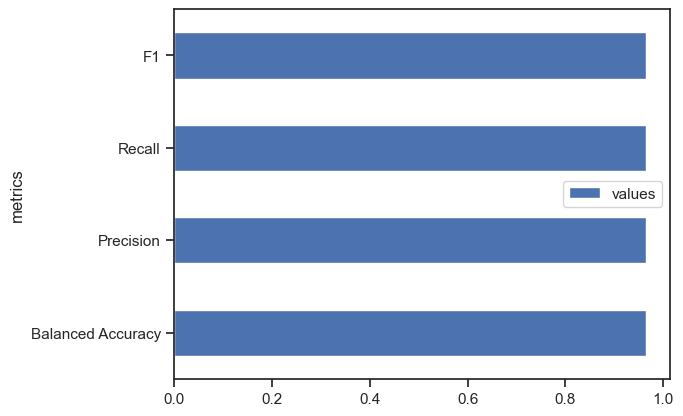

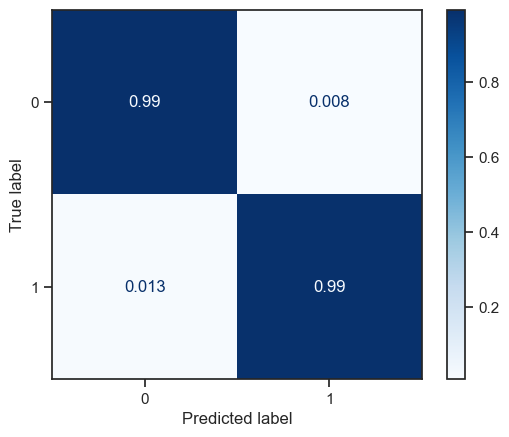

GradientBoosting
Balanced Accuracy: 0.9563492063492063
Precision: 0.9548613209257356
Recall: 0.9532163742690059
F1: 0.9534947673974487


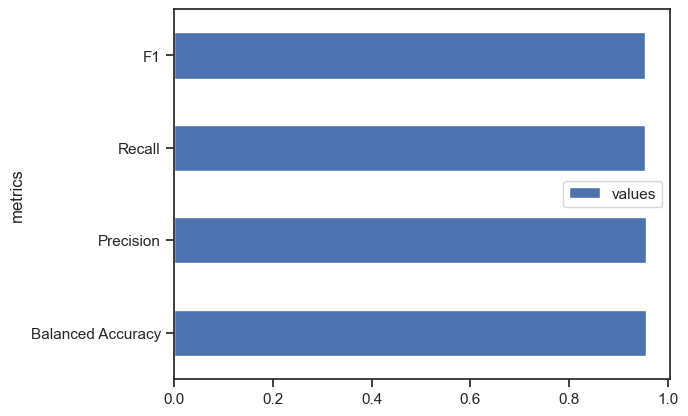

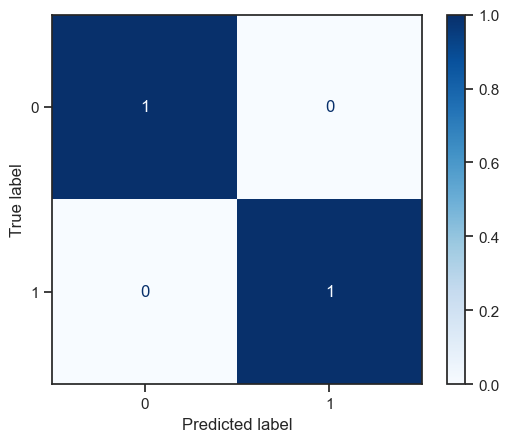

Best GradientBoosting
Balanced Accuracy: 0.953042328042328
Precision: 0.9537850431594226
Recall: 0.9532163742690059
F1: 0.9533632562715197


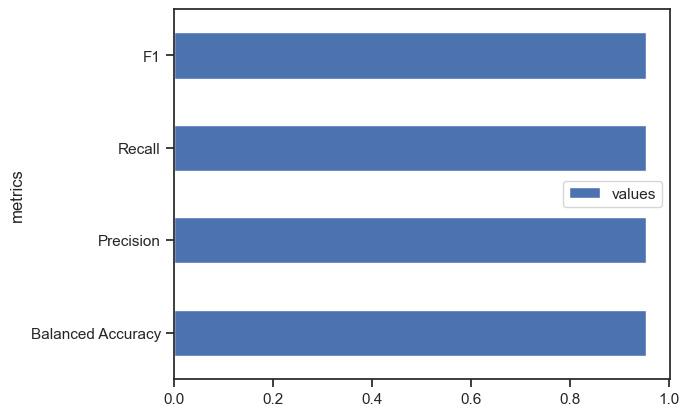

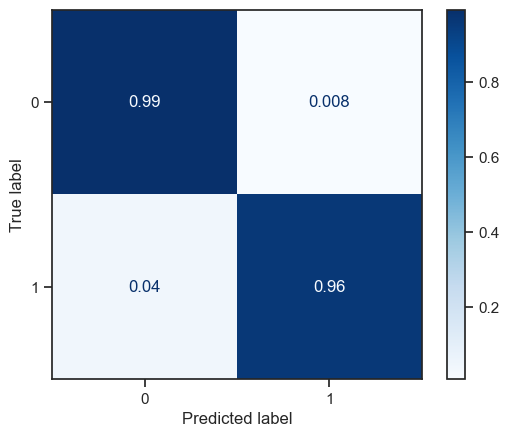

In [51]:
for name, model in all_models.items():
    est = model.fit(x_train, y_train)
    y_pred = est.predict(x_test)
    print(name)
    print_metrics(model, y_test, y_pred)

Вывод: на основании используемых метрик наилучшей моделью оказалась baseline-модель метода опорных векторов. 

Кросс-валидация показала лучший результат для модели дерева решений, так как до подбора параметра значения метрик были относительно небольшими.